# Mathematical Underpinnings - Lab 7

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

## Task 1

### a)

In [2]:
def KL_mult_normal(mu1, mu2, Sigma1, Sigma2):
    n = mu1.shape[0]
    term1 = np.dot(np.dot((mu2 - mu1).T, np.linalg.inv(Sigma2)), (mu2 - mu1))
    term2 = np.trace(np.linalg.inv(Sigma2) @ Sigma1)
    term3 = np.log(np.linalg.det(Sigma1) / np.linalg.det(Sigma2))
    
    return 0.5 * ( term1 + term2 - term3 - n )


# Example mean vectors
mu1 = np.array([0, 0])
mu2 = np.array([1, 1])

# Example covariance matrices
Sigma1 = np.array([[1, 0.5], [0.5, 1]])
Sigma2 = np.array([[2, 0], [0, 2]])

# Compute KL divergence
kl_divergence = KL_mult_normal(mu1, mu2, Sigma1, Sigma2)
print("KL Divergence:", kl_divergence)

KL Divergence: 0.8369882167858358


In [3]:
def T_opt(x, mu1, mu2, Sigma1, Sigma2):
    # Compute log(p(x)/q(x)), where p and q are multivariate normal with parameters mu1, Sigma1 and mu2, Sigma2 respectively
    term1 = np.log(np.linalg.det(Sigma2)) - np.log(np.linalg.det(Sigma1))
    
    # Calculate term2 for each row in x
    term2 = np.array([np.dot(np.dot((xi - mu2), np.linalg.inv(Sigma2)), (xi - mu2)) for xi in x])
    
    # Calculate term3 for each row in x
    term3 = np.array([np.dot(np.dot((xi - mu1), np.linalg.inv(Sigma1)), (xi - mu1)) for xi in x])
    
    return 0.5 * (term1 + term2 - term3)
    
# Compute logarithm of likelihood ratio
x = np.array([0.5, 0.3])
log_likelihood_ratio = T_opt(x, mu1, mu2, Sigma1, Sigma2)
print("Log Likelihood Ratio at x:", log_likelihood_ratio)

Log Likelihood Ratio at x: [0.79532155 1.02198822]


### b)

In [4]:
# sample n = 10000 observations out of np.random.multivariate_normal(mu1, Sigma1, size=n)
# and sample n = 10000 observations out of np.random.multivariate_normal(mu2, Sigma2, size=n)
# then concatenate the two matrices (your final x is a matrix 2n x 5)
# then create a vector y that will have n ones and n zeros (of size 2n)

# Define parameters
mu1 = np.array([0.2, 0.2, 0.2, 0, 0])
mu2 = np.array([0, 0, 0.2, 0.2, 0.2])

rho1 = 0.1
rho2 = -0.2

Sigma1 = np.array([[1, rho1, rho1, rho1, rho1],
                   [rho1, 1, rho1, rho1, rho1],
                   [rho1, rho1, 1, rho1, rho1],
                   [rho1, rho1, rho1, 1, rho1],
                   [rho1, rho1, rho1, rho1, 1]])

Sigma2 = np.array([[1, rho2, rho2, rho2, rho2],
                   [rho2, 1, rho2, rho2, rho2],
                   [rho2, rho2, 1, rho2, rho2],
                   [rho2, rho2, rho2, 1, rho2],
                   [rho2, rho2, rho2, rho2, 1]])

n = 10000

# Sample from the distributions
samples1 = np.random.multivariate_normal(mu1, Sigma1, size=n)
samples2 = np.random.multivariate_normal(mu2, Sigma2, size=n)

# Concatenate the samples
x = np.concatenate([samples1, samples2])

# Create labels
y = np.concatenate([np.ones(n), np.zeros(n)])

In [5]:
def DV_fun(y, t):
    # y - an indicator [y[i]=1 if t[i] corresponds to x sampled from the distribution p, y[i]=0 otherwise]
    # t a vector (of the same length as y) t = log(p(x)/q(x))
    return np.mean(t[y == 1]) - np.log(np.mean(np.exp(t[y == 0])))

In [6]:
kl_divergence = KL_mult_normal(mu1, mu2, Sigma1, Sigma2)
print("KL Divergence:", kl_divergence)

KL Divergence: 2.169075737042572


In [8]:
DV_fun(y, T_opt(x, mu1, mu2, Sigma1, Sigma2))

2.4350216217716585

### c)

In [9]:
def DV_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true))/n1
    second_term = tf.math.log(tf.math.reduce_sum(tf.math.multiply(tf.math.exp(T_x), tf.subtract(tf.convert_to_tensor(1.0), y_true)))/n2)
    return -(first_term - second_term) 

### d)

In [10]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=DV_loss)

2024-04-24 14:47:58.850277: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [12]:
hist = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/100
15/15 [==============================] - 1s 17ms/step - loss: 0.1277 - val_loss: 0.0736
Epoch 2/100
15/15 [==============================] - 0s 6ms/step - loss: 0.0421 - val_loss: 0.0117
Epoch 3/100
15/15 [==============================] - 0s 7ms/step - loss: -0.0069 - val_loss: -0.0249
Epoch 4/100
15/15 [==============================] - 0s 6ms/step - loss: -0.0367 - val_loss: -0.0480
Epoch 5/100
15/15 [==============================] - 0s 7ms/step - loss: -0.0558 - val_loss: -0.0623
Epoch 6/100
15/15 [==============================] - 0s 6ms/step - loss: -0.0678 - val_loss: -0.0719
Epoch 7/100
15/15 [==============================] - 0s 6ms/step - loss: -0.0762 - val_loss: -0.0782
Epoch 8/100
15/15 [==============================] - 0s 6ms/step - loss: -0.0819 - val_loss: -0.0826
Epoch 9/100
15/15 [==============================] - 0s 6ms/step - loss: -0.0860 - val_loss: -0.0856
Epoch 10/100
15/15 [==============================] - 0s 6ms/step - loss: -0.0888 - val_loss: 

15/15 [==============================] - 0s 10ms/step - loss: -2.4136 - val_loss: -2.4528
Epoch 82/100
15/15 [==============================] - 0s 10ms/step - loss: -2.3497 - val_loss: -2.4177
Epoch 83/100
15/15 [==============================] - 0s 6ms/step - loss: -2.3572 - val_loss: -2.3622
Epoch 84/100
15/15 [==============================] - 0s 10ms/step - loss: -2.3714 - val_loss: -2.3839
Epoch 85/100
15/15 [==============================] - 0s 9ms/step - loss: -2.4249 - val_loss: -2.3228
Epoch 86/100
15/15 [==============================] - 0s 17ms/step - loss: -2.4323 - val_loss: -2.3983
Epoch 00086: early stopping


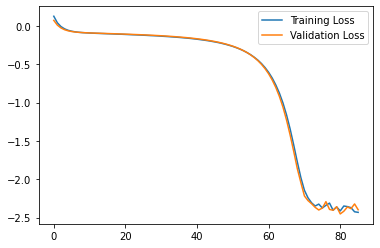

In [13]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### e)

In [14]:
t_x_pred = model.predict( x )

In [15]:
t_x_opt = T_opt( x, mu1, mu2, Sigma1, Sigma2)

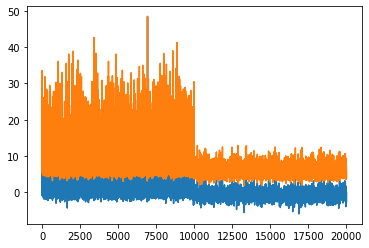

In [16]:
plt.plot(t_x_opt)
plt.plot(t_x_pred)

plt.show()

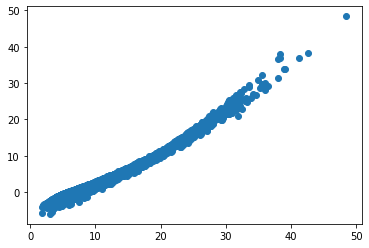

In [17]:
plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [18]:
DV_fun(y, t_x_pred)

2.3632183

In [19]:
DV_fun(y, t_x_opt)

2.4350216217716585

In [20]:
# new data
x_new = np.concatenate(
    [
        np.random.multivariate_normal(mu1, Sigma1, n),
        np.random.multivariate_normal(mu2, Sigma2, n),
    ]
)
y_new = np.repeat([1, 0], n)

t_x_pred = model.predict(x_new)[:, 0]
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)
print("DV_fun of model: ", DV_fun(y_new, t_x_pred) )
print("DV_fun of T_opt: ", DV_fun(y_new, t_x_opt) )

DV_fun of model:  1.620008
DV_fun of T_opt:  2.1599793253771615


### f)

In [21]:
def NWJ_loss(y_true, T_x):
    n1 = tf.math.reduce_sum(y_true)
    n2 = tf.math.reduce_sum(tf.subtract(tf.convert_to_tensor(1.0), y_true))
    first_term = tf.math.reduce_sum(tf.math.multiply(T_x, y_true)) / n1
    second_term = (
        tf.math.reduce_sum(
            tf.math.multiply(
                tf.math.exp(tf.subtract(T_x, tf.convert_to_tensor(1.0))),
                tf.subtract(tf.convert_to_tensor(1.0), y_true),
            )
        )
        / n2
    )
    return -(first_term - second_term)

def NWJ_fun(y, t):
    return np.mean(t[y == 1]) - np.mean(np.exp(t[y == 0] - 1))

In [22]:
model_inputs = keras.Input(shape=(5))
layer_out = Dense(64, activation='softplus')(model_inputs)
#layer_out = Dense(125, activation='tanh')(layer_out)
layer_out = Dense(64)(layer_out)
model_outputs = Dense(1)(layer_out)
model = keras.Model(model_inputs, model_outputs)

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.compile(optimizer=optimizer, loss=NWJ_loss)

hist = model.fit(x_train, y_train, epochs=200, batch_size=1024, validation_data=(x_test, y_test), callbacks=[es])


Epoch 1/200
15/15 [==============================] - 1s 34ms/step - loss: 0.0188 - val_loss: -0.0124
Epoch 2/200
15/15 [==============================] - 0s 7ms/step - loss: -0.0227 - val_loss: -0.0394
Epoch 3/200
15/15 [==============================] - 0s 8ms/step - loss: -0.0449 - val_loss: -0.0545
Epoch 4/200
15/15 [==============================] - 0s 6ms/step - loss: -0.0576 - val_loss: -0.0629
Epoch 5/200
15/15 [==============================] - 0s 6ms/step - loss: -0.0658 - val_loss: -0.0682
Epoch 6/200
15/15 [==============================] - 0s 6ms/step - loss: -0.0709 - val_loss: -0.0711
Epoch 7/200
15/15 [==============================] - 0s 9ms/step - loss: -0.0743 - val_loss: -0.0727
Epoch 8/200
15/15 [==============================] - 0s 8ms/step - loss: -0.0780 - val_loss: -0.0756
Epoch 9/200
15/15 [==============================] - 0s 13ms/step - loss: -0.0798 - val_loss: -0.0772
Epoch 10/200
15/15 [==============================] - 0s 10ms/step - loss: -0.0820 - val_l

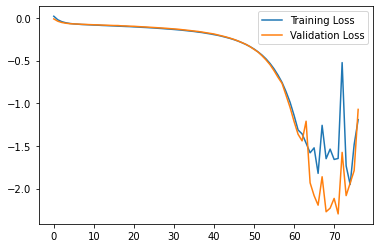

In [23]:
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


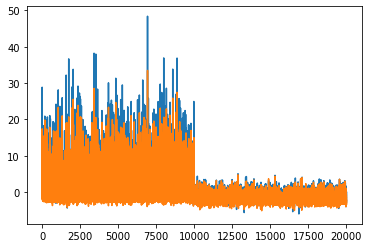

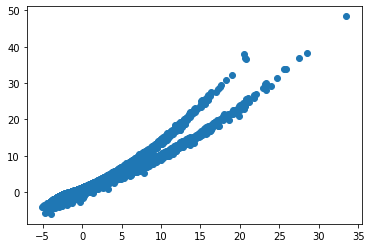

In [24]:
t_x_pred = model.predict( x )
t_x_opt = T_opt( x, mu1, mu2, Sigma1, Sigma2)

plt.plot(t_x_opt)
plt.plot(t_x_pred)
plt.show()

plt.plot(t_x_pred, t_x_opt, "o")
plt.show()

In [25]:
print("DV_fun of model: ", DV_fun(y, t_x_pred) )
print("DV_fun of T_opt: ", DV_fun(y, t_x_opt) )

DV_fun of model:  2.2083244
DV_fun of T_opt:  2.4350216217716585


In [26]:
# new data
x_new = np.concatenate(
    [
        np.random.multivariate_normal(mu1, Sigma1, n),
        np.random.multivariate_normal(mu2, Sigma2, n),
    ]
)
y_new = np.repeat([1, 0], n)

t_x_pred = model.predict(x_new)[:, 0]
t_x_opt = T_opt(x_new, mu1, mu2, Sigma1, Sigma2)
print("NWJ_fun of model: ", NWJ_fun(y_new, t_x_pred) )
print("NWJ_fun of T_opt: ", NWJ_fun(y_new, t_x_opt) )

NWJ_fun of model:  0.58302087
NWJ_fun of T_opt:  1.7609457509563309
